In [1]:
import PIL.Image as Image
import numpy as np
from sms.data.utils.detic_dataloader import DeticDataloader

im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6408.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

detic = DeticDataloader()
detic.create()
detic.default_vocab()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/yujustin/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/18 01:49:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [2]:
out = detic.predict(np_frame1)

(480, 640, 3)


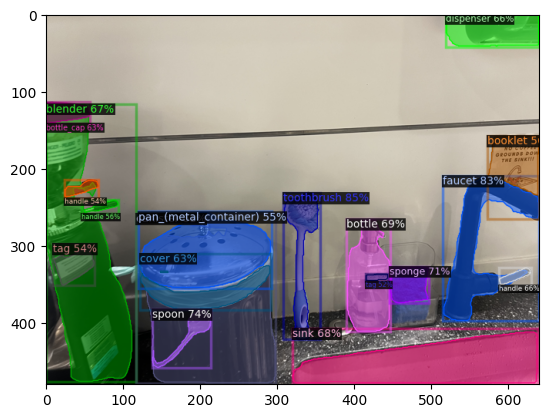

In [3]:
import matplotlib.pyplot as plt 
output_im = out[0].get_image()
print(output_im.shape)
plt.imshow(output_im)

(480, 640, 3)


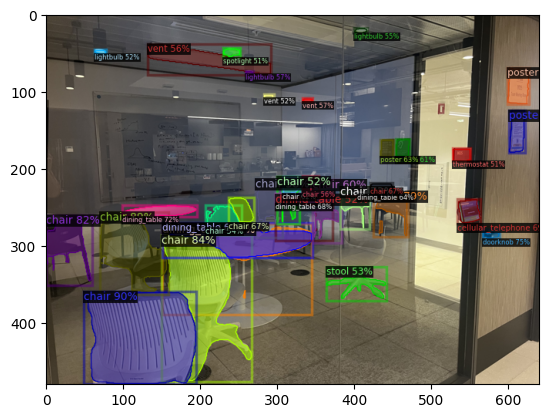

In [4]:
im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6409.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)
out = detic.predict(np_frame1)
output_im = out[0].get_image()
print(output_im.shape)
plt.imshow(output_im)

(480, 640, 3)


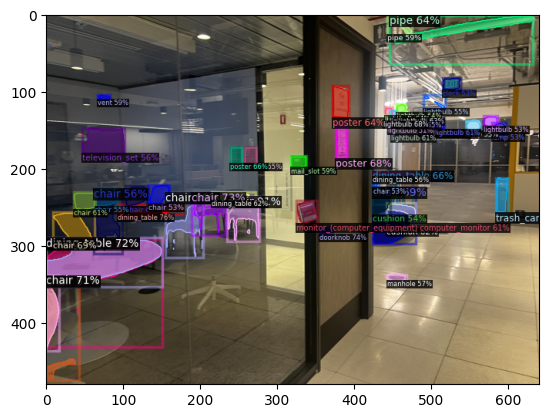

In [5]:
im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6411.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)
out = detic.predict(np_frame1)
output_im = out[0].get_image()
print(output_im.shape)
plt.imshow(output_im)

In [ ]:
im_frame1 = Image.open('/home/yujustin/Desktop/sms/sms/scripts/test_imgs/BWWK/IMG_6414.jpeg')
im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)
out = detic.predict(np_frame1)
output_im = out[0].get_image()
print(output_im.shape)
plt.imshow(output_im)